In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [2]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

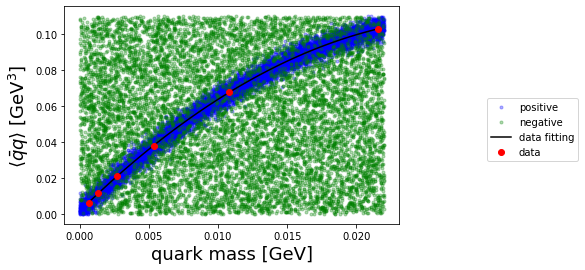

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=10000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [6]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss1(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output*(2-answer), answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss
    def loss2(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss
def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

In [43]:
# parameters
d = 4
m2 = -3 # mass^2
N_layer = 15
Delta_plus = d/2 +1
Delta_minus= d/2 -1
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
# making network
Test = MetricNet(Number_of_layers=N_layer, 
                         eta_ini=eta_ini, 
                         eta_fin=eta_fin,
                         m2=m2, 
                         del_eta=del_eta,
                         d=d)
init_weights(Test, d)
# setting it to be trained
optimizer = optim.Adam(Test.parameters()) 
Test.train()
# For regularization terms
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1,  1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(0.001*eta(i, eta_ini, eta_fin, N_layer)**4)
print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
print("H: ", np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
H:  [ 2.4944797   2.9306302   1.0511909   4.9796863  -0.35750186  2.3240795
  9.435591    5.831734    4.9549665   3.2428308   1.9436836   0.45487818
  6.4232464   1.9366283   1.3560349 ]


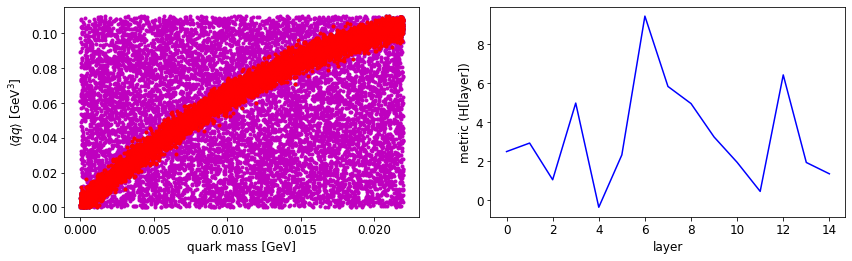

In [44]:
negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )

# 3. Train your NN

In [45]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='NN(positive)=/=0')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

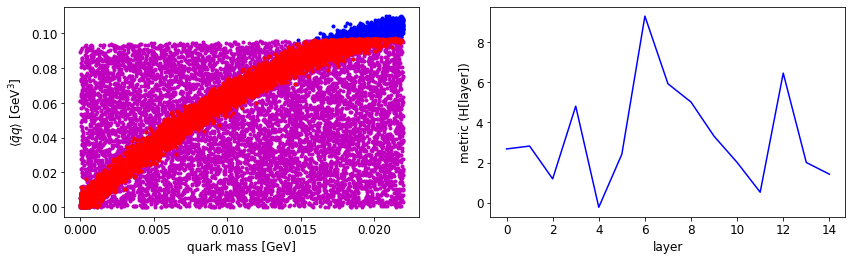

training epoch: 0,   loss: 0.30880510807037354
lambda: 0.2367260605096817,   AdS radius: 0.8661261200904846[1/GeV]
[ 2.680639    2.8248148   1.1940216   4.8091784  -0.21895285  2.4166422
  9.288252    5.9230785   5.0123444   3.3124695   2.0100749   0.528959
  6.4526086   2.0072906   1.4254272 ]


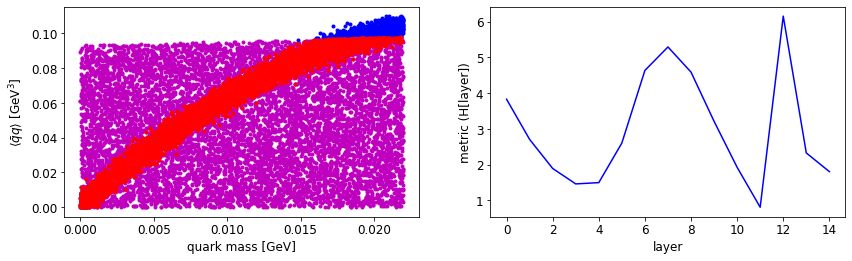

training epoch: 100,   loss: 0.2512982189655304
lambda: -2.3580617904663086,   AdS radius: 0.9640323519706726[1/GeV]
[3.8292263  2.70624    1.8925844  1.4608516  1.4964867  2.6038675
 4.6351233  5.291295   4.5882382  3.211717   1.9251947  0.80797654
 6.1542153  2.3267677  1.8046267 ]


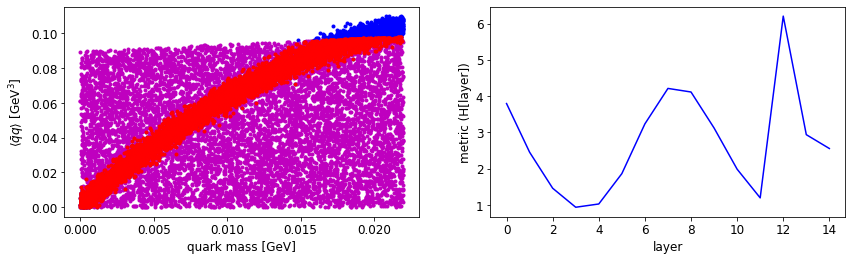

training epoch: 200,   loss: 0.24688051640987396
lambda: -5.030677318572998,   AdS radius: 1.1298350095748901[1/GeV]
[3.7951858  2.4543626  1.4615818  0.93779093 1.0277518  1.8637197
 3.235381   4.212274   4.1133604  3.121646   1.9865539  1.1959034
 6.2045584  2.937768   2.556398  ]


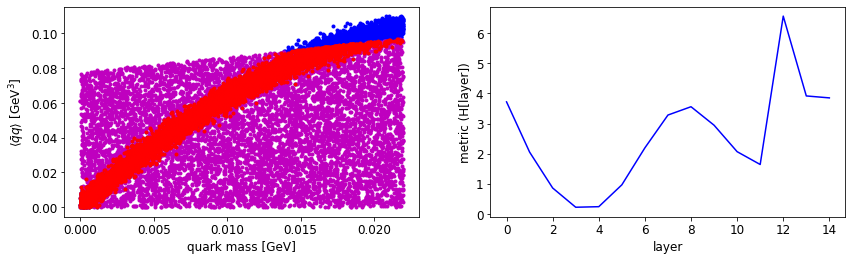

training epoch: 300,   loss: 0.2349291294813156
lambda: -8.217775344848633,   AdS radius: 1.5541281700134277[1/GeV]
[3.720684   2.0521774  0.8595796  0.22041221 0.23901546 0.96467453
 2.1940386  3.2833369  3.5593557  2.9453063  2.0662107  1.640627
 6.5694084  3.9176462  3.85317   ]


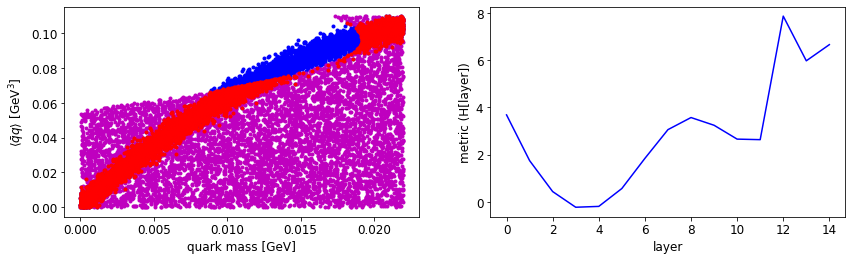

training epoch: 400,   loss: 0.20989848673343658
lambda: -8.196429252624512,   AdS radius: 1.7998028993606567[1/GeV]
[ 3.6839278   1.7482489   0.43796602 -0.22504257 -0.18899125  0.5672072
  1.8436108   3.059948    3.57169     3.2451062   2.658612    2.6359394
  7.865207    5.973232    6.657563  ]


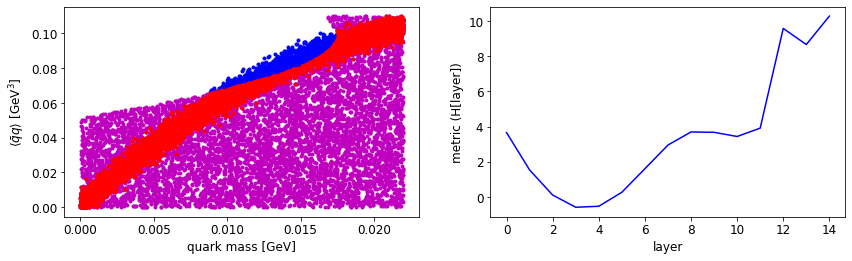

training epoch: 500,   loss: 0.19172844290733337
lambda: -7.4606757164001465,   AdS radius: 1.764111876487732[1/GeV]
[ 3.660518    1.537067    0.11230922 -0.57972026 -0.5243385   0.2709241
  1.6074517   2.9521117   3.6954904   3.675771    3.4382892   3.9135609
  9.573886    8.660848   10.27459   ]


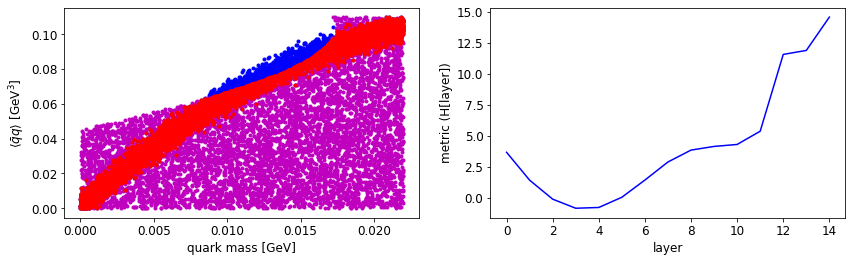

training epoch: 600,   loss: 0.17361518740653992
lambda: -6.36544132232666,   AdS radius: 1.7216761112213135[1/GeV]
[ 3.6569817   1.4040933  -0.13134009 -0.8666832  -0.8046854   0.02109272
  1.4113438   2.8721294   3.834285    4.1303196   4.289189    5.359503
 11.567864   11.889997   14.583322  ]


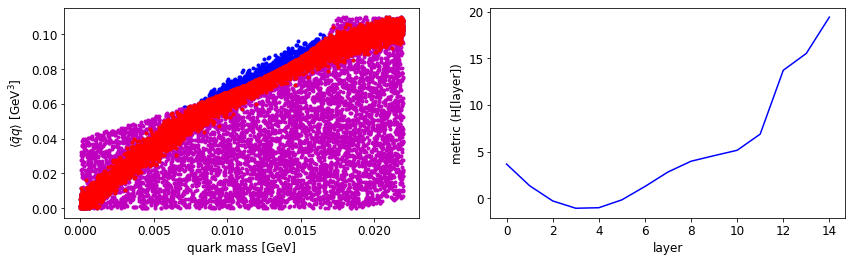

training epoch: 700,   loss: 0.1566389799118042
lambda: -4.860738277435303,   AdS radius: 1.6875736713409424[1/GeV]
[ 3.655749    1.3325025  -0.29762915 -1.0848031  -1.0291976  -0.18507087
  1.2460703   2.8028746   3.9580297   4.556857    5.1329494   6.867034
 13.714682   15.525882   19.421171  ]


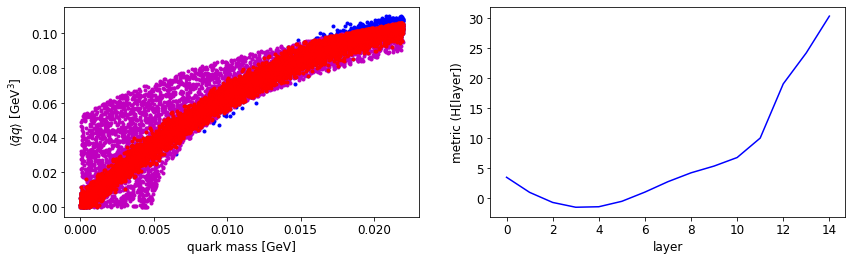

training epoch: 800,   loss: 0.04452230781316757
lambda: 0.2127436101436615,   AdS radius: 2.6740689277648926[1/GeV]
[ 3.4867668   0.97425586 -0.70435834 -1.5045974  -1.4218113  -0.51678425
  1.0161246   2.7537596   4.228489    5.3521647   6.7742105  10.014455
 19.044388   24.211246   30.326332  ]


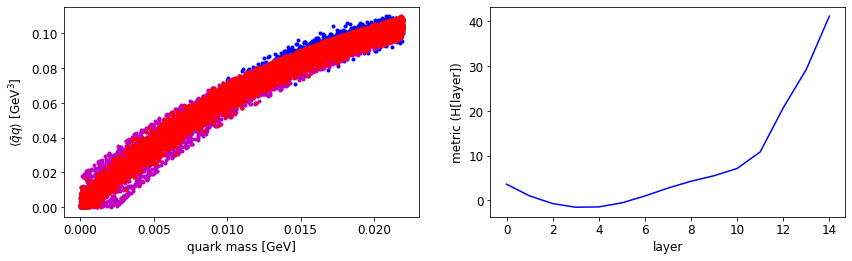

training epoch: 900,   loss: 0.025298960506916046
lambda: 0.01273420825600624,   AdS radius: 3.39159893989563[1/GeV]
[ 3.6039968  0.9931152 -0.7287027 -1.5487361 -1.4732486 -0.5678314
  0.9723031  2.7329128  4.2633305  5.496413   7.1230893 10.823379
 20.683468  29.286512  41.19839  ]


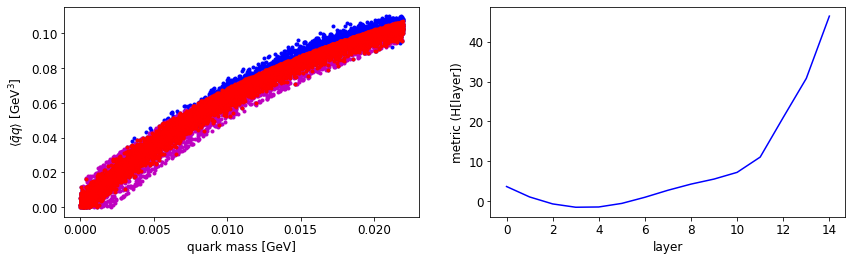

training epoch: 1000,   loss: 0.022954296320676804
lambda: 0.011615834198892117,   AdS radius: 3.4149210453033447[1/GeV]
[ 3.6439438   1.0258203  -0.7247565  -1.5599623  -1.4924574  -0.59181035
  0.9451444   2.707704    4.252293    5.5182357   7.205743   11.040402
 20.999739   30.801033   46.443993  ]


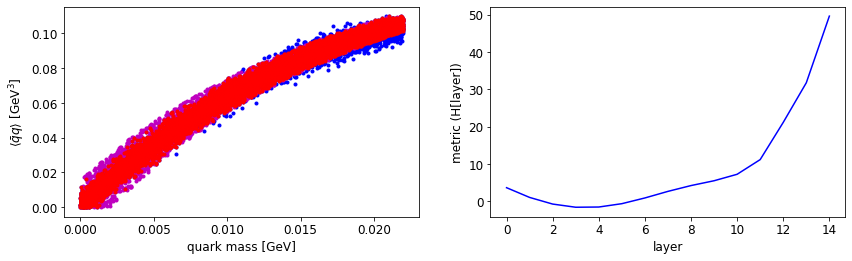

training epoch: 1100,   loss: 0.022201472893357277
lambda: 0.014758230186998844,   AdS radius: 3.3096230030059814[1/GeV]
[ 3.6658175   1.0600077  -0.71676135 -1.5673771  -1.5083636  -0.6133281
  0.9190426   2.6809769   4.234916    5.5249124   7.256527   11.184577
 21.147905   31.751736   49.589527  ]


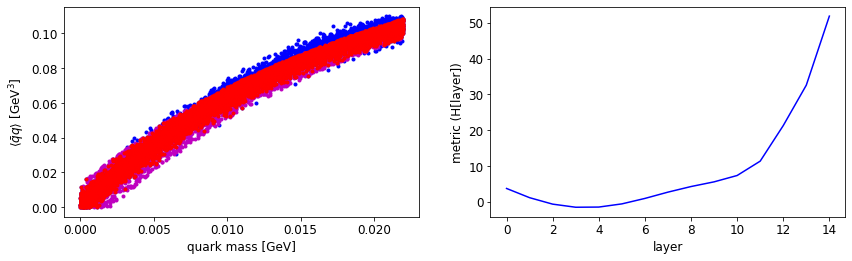

training epoch: 1200,   loss: 0.022449100390076637
lambda: 0.017475474625825882,   AdS radius: 3.2195470333099365[1/GeV]
[ 3.6836526   1.1019179  -0.70092475 -1.5688787  -1.5195985  -0.63116056
  0.8956219   2.6559224   4.2183075   5.5314145   7.30542    11.31966
 21.259542   32.567425   51.87064   ]


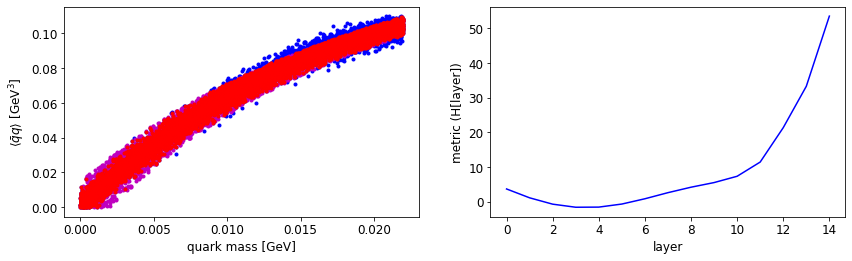

training epoch: 1300,   loss: 0.021979890763759613
lambda: 0.023071670904755592,   AdS radius: 3.1405556201934814[1/GeV]
[ 3.6933088   1.1419368  -0.68519795 -1.5717303  -1.533047   -0.65185153
  0.8687119   2.6266782   4.1968107   5.532077    7.346949   11.440487
 21.343245   33.25847    53.461975  ]


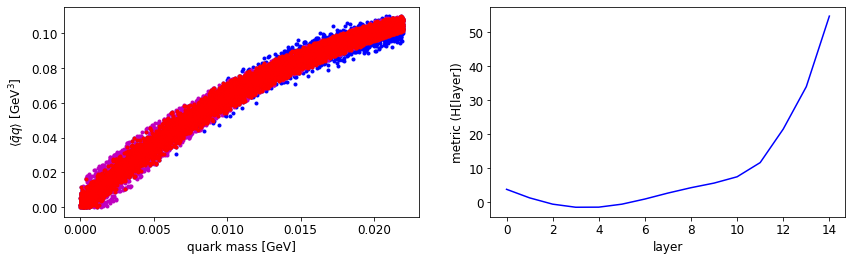

training epoch: 1400,   loss: 0.021596724167466164
lambda: 0.02539190649986267,   AdS radius: 3.071094512939453[1/GeV]
[ 3.7011797   1.1839252  -0.6656892  -1.572254   -1.5452211  -0.67196697
  0.841785    2.5969684   4.17467     5.5323944   7.3887258  11.559457
 21.421867   33.883488   54.63333   ]


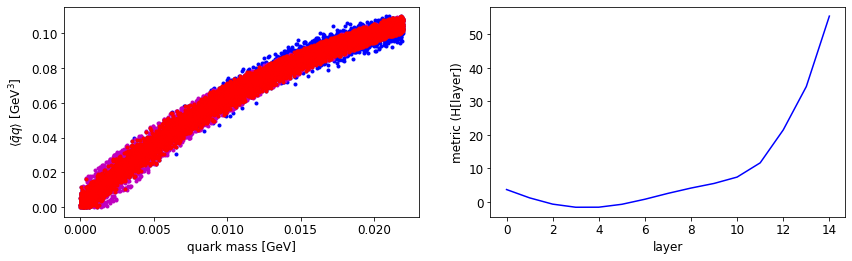

training epoch: 1500,   loss: 0.022354120388627052
lambda: 0.030261630192399025,   AdS radius: 3.0066959857940674[1/GeV]
[ 3.7078521  1.225822  -0.6436148 -1.571062  -1.5564535 -0.6916581
  0.8148798  2.5669527  4.151932   5.5319443  7.4295626 11.673866
 21.495453  34.425068  55.443043 ]


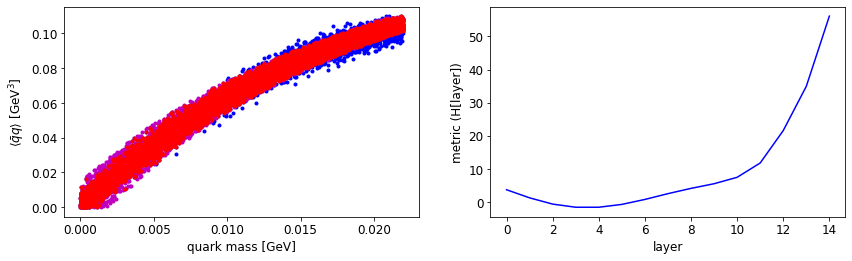

training epoch: 1600,   loss: 0.02198590338230133
lambda: 0.03367486596107483,   AdS radius: 2.960923433303833[1/GeV]
[ 3.7129333   1.2665575  -0.620287   -1.569659   -1.5684465  -0.71271074
  0.7862115   2.5349972   4.12746     5.530644    7.471285   11.789973
 21.579596   34.939404   56.136684  ]


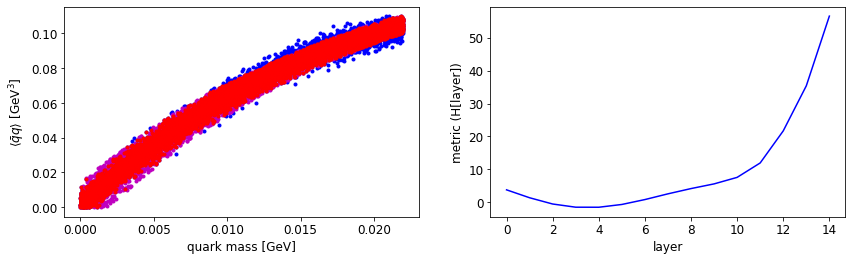

training epoch: 1700,   loss: 0.02159227803349495
lambda: 0.03550043702125549,   AdS radius: 2.9240036010742188[1/GeV]
[ 3.7187846   1.3077579  -0.59390557 -1.5659385  -1.5790739  -0.7330109
  0.75785816  2.5030608   4.1029873   5.5295353   7.5138683  11.904836
 21.664606   35.38367    56.600197  ]


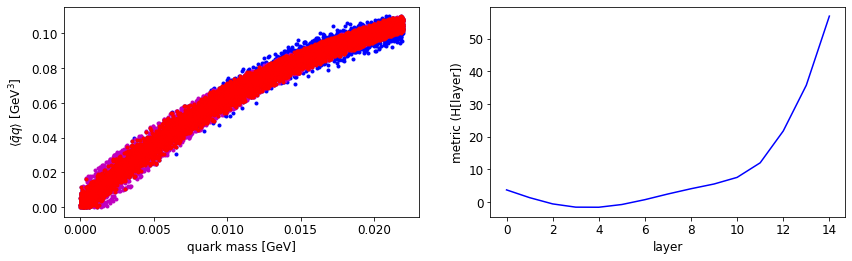

training epoch: 1800,   loss: 0.020926501601934433
lambda: 0.04094492644071579,   AdS radius: 2.888563394546509[1/GeV]
[ 3.7227814   1.3453252  -0.56817955 -1.5626254  -1.5905101  -0.7543529
  0.7283709   2.469917    4.0770087   5.526583    7.55403    12.013652
 21.748793   35.756844   56.917324  ]


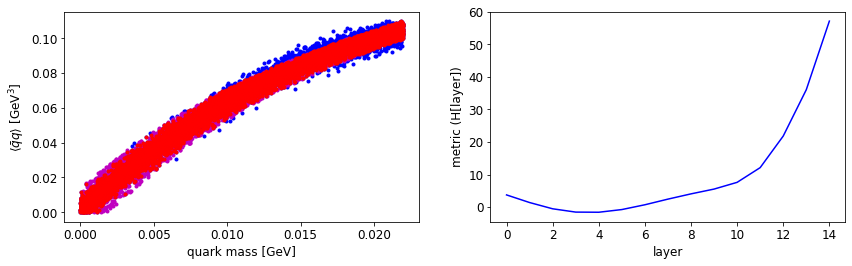

training epoch: 1900,   loss: 0.021459495648741722
lambda: 0.04318375140428543,   AdS radius: 2.869882822036743[1/GeV]
[ 3.7274027   1.3828702  -0.54017067 -1.5574857  -1.6010519  -0.775392
  0.69881445  2.4365277   4.050951    5.5241737   7.596142   12.124332
 21.84111    36.092888   57.182034  ]


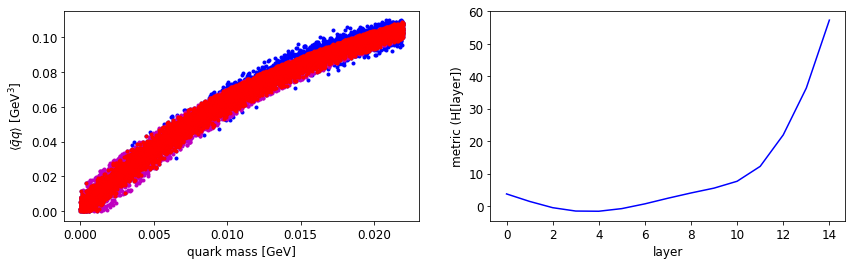

training epoch: 2000,   loss: 0.020911354571580887
lambda: 0.04680357128381729,   AdS radius: 2.8465421199798584[1/GeV]
[ 3.7316303  1.4181538 -0.5119161 -1.5514853 -1.611022  -0.7960679
  0.6695726  2.4034033  4.024879   5.5212455  7.636766  12.229562
 21.92971   36.35998   57.320366 ]


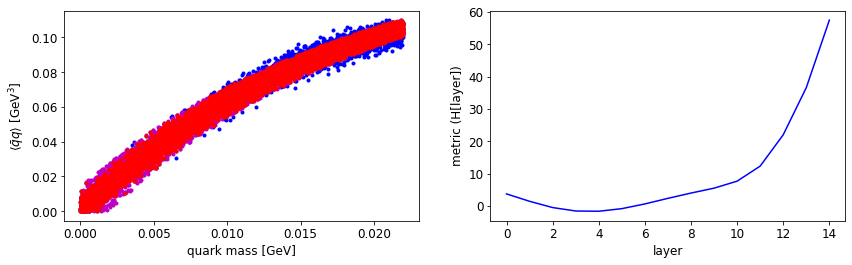

training epoch: 2100,   loss: 0.020664941519498825
lambda: 0.047482967376708984,   AdS radius: 2.821258306503296[1/GeV]
[ 3.734956    1.4509741  -0.48394567 -1.5451465  -1.6209598  -0.81691086
  0.64013326  2.370098    3.9986188   5.5180135   7.6769567  12.332361
 22.02134    36.592224   57.44857   ]


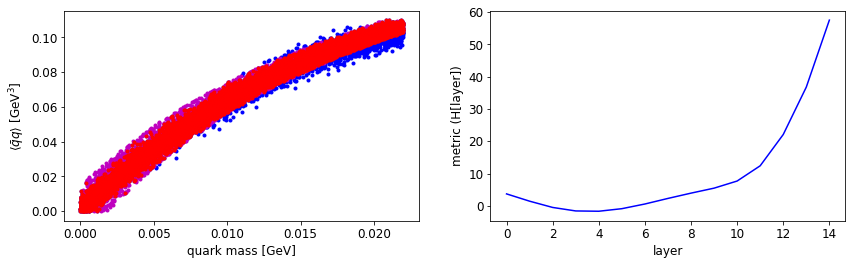

training epoch: 2200,   loss: 0.020474502816796303
lambda: 0.051967598497867584,   AdS radius: 2.797347068786621[1/GeV]
[ 3.737391   1.4816804 -0.4562644 -1.5387725 -1.6314129 -0.8386814
  0.6095516  2.3355355  3.9710708  5.5136223  7.716178  12.432596
 22.111847  36.782867  57.502525 ]


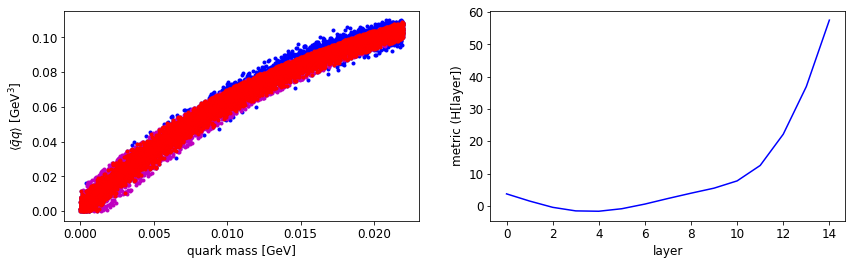

training epoch: 2300,   loss: 0.020819170400500298
lambda: 0.05409843474626541,   AdS radius: 2.7803874015808105[1/GeV]
[ 3.7426233   1.5138676  -0.42545712 -1.5285236  -1.6382536  -0.857074
  0.5822812   2.3042886   3.946697    5.5121527   7.7579155  12.532744
 22.203865   36.939793   57.52047   ]


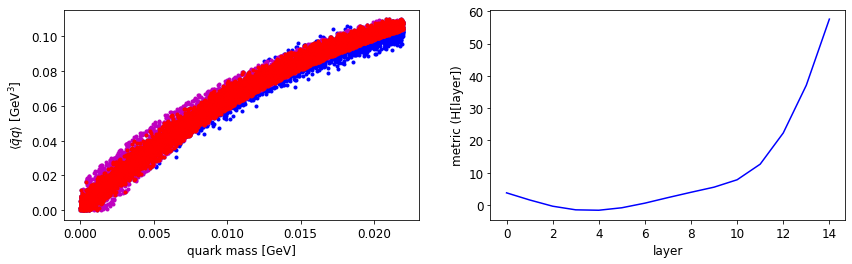

training epoch: 2400,   loss: 0.020578214898705482
lambda: 0.05670049041509628,   AdS radius: 2.766396999359131[1/GeV]
[ 3.743344    1.540384   -0.39887154 -1.5218811  -1.6490804  -0.87975407
  0.5506217   2.2686741   3.9180493   5.506683    7.7961073  12.629034
 22.296822   37.086697   57.580727  ]


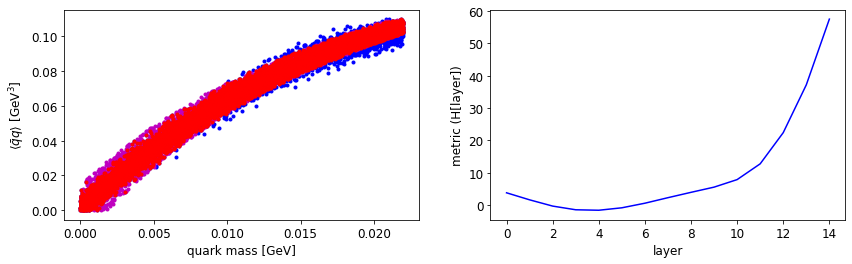

training epoch: 2500,   loss: 0.020537741482257843
lambda: 0.05934400483965874,   AdS radius: 2.752455472946167[1/GeV]
[ 3.7472386   1.5689207  -0.36902073 -1.5111917  -1.656091   -0.8988983
  0.52238923  2.2364      3.8925805   5.5040393   7.8365135  12.724567
 22.386501   37.193497   57.550636  ]


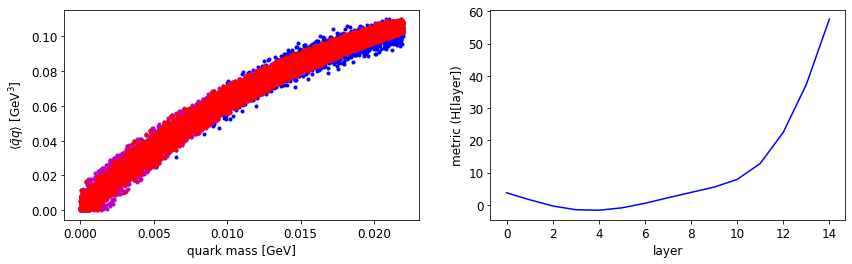

training epoch: 2600,   loss: 0.021175861358642578
lambda: 0.05890326574444771,   AdS radius: 2.7396721839904785[1/GeV]
[ 3.7505155   1.5958881  -0.3395961  -1.5002586  -1.6631653  -0.91842115
  0.4936793   2.2037125   3.8668718   5.501617    7.8779125  12.821547
 22.483389   37.311802   57.60184   ]


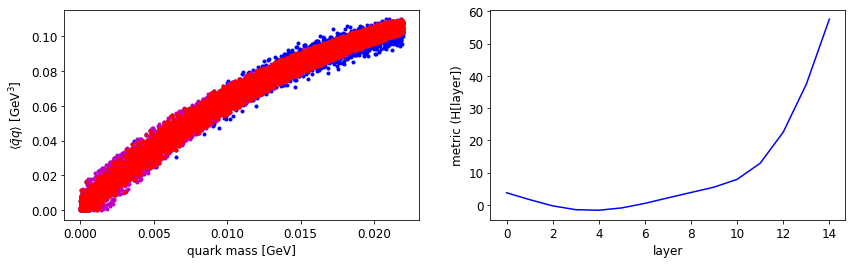

training epoch: 2700,   loss: 0.019997447729110718
lambda: 0.06129753962159157,   AdS radius: 2.7252938747406006[1/GeV]
[ 3.7532728   1.6210101  -0.31112856 -1.4891374  -1.6699005  -0.93761814
  0.46537086  2.1715055   3.8414612   5.498975    7.9180317  12.914491
 22.57626    37.40944    57.624615  ]


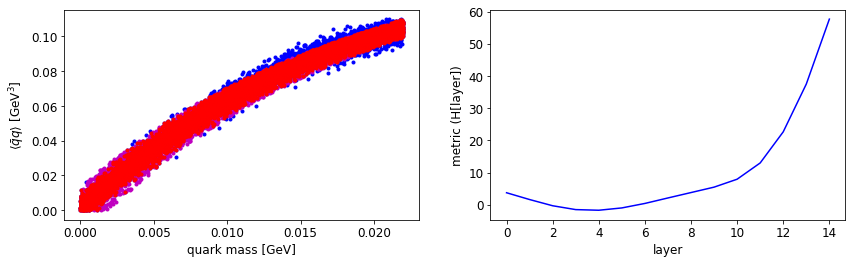

training epoch: 2800,   loss: 0.01975332200527191
lambda: 0.062250856310129166,   AdS radius: 2.7206106185913086[1/GeV]
[ 3.7566867   1.646303   -0.28163117 -1.4765383  -1.6756701  -0.9563683
  0.43724933  2.1394107   3.8163228   5.497077    7.9596715  13.009
 22.671875   37.50432    57.662125  ]


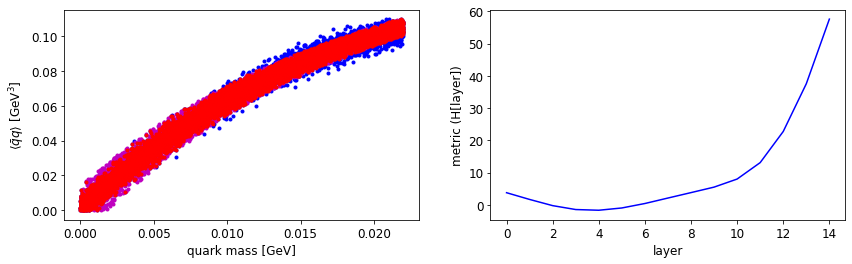

training epoch: 2900,   loss: 0.020003078505396843
lambda: 0.06649588793516159,   AdS radius: 2.7069091796875[1/GeV]
[ 3.7584457   1.6688524  -0.25422806 -1.4650152  -1.6824126  -0.97620225
  0.40803093  2.1061924   3.789851    5.4933395   7.9984336  13.097601
 22.758127   37.566784   57.620827  ]


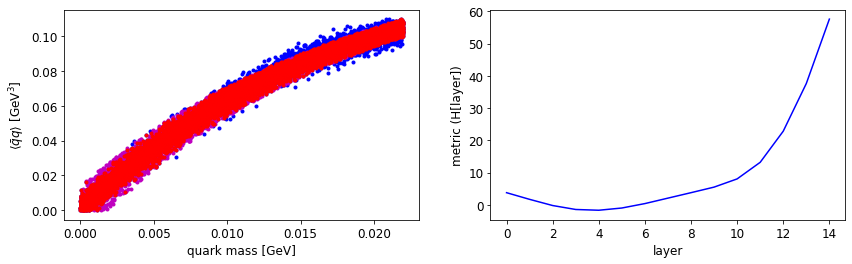

training epoch: 3000,   loss: 0.020034179091453552
lambda: 0.06580992788076401,   AdS radius: 2.70552659034729[1/GeV]
[ 3.7613034   1.6918403  -0.22581263 -1.451797   -1.6876664  -0.9948774
  0.37983084  2.074011    3.7645385   5.4910493   8.039056   13.187807
 22.848892   37.638695   57.6315    ]


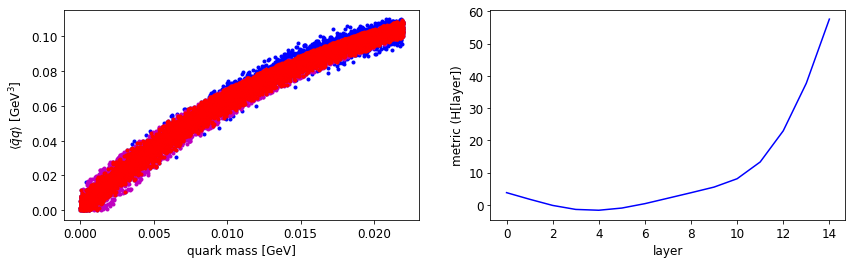

training epoch: 3100,   loss: 0.019766030833125114
lambda: 0.06614610552787781,   AdS radius: 2.699714422225952[1/GeV]
[ 3.7641137   1.7138577  -0.19793268 -1.4381632  -1.6923379  -1.0130851
  0.35207695  2.0422723   3.7394476   5.4884715   8.078227   13.273697
 22.931591   37.68347    57.56722   ]


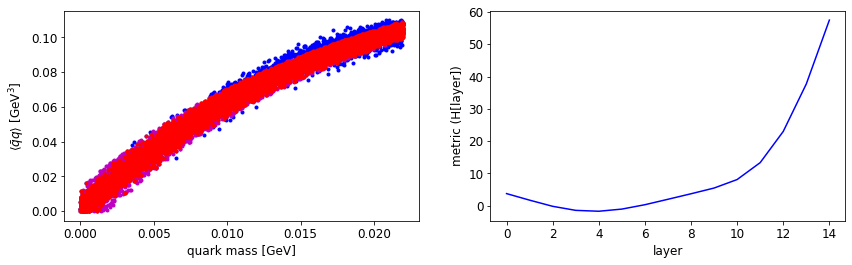

training epoch: 3200,   loss: 0.019896982237696648
lambda: 0.06841697543859482,   AdS radius: 2.6976065635681152[1/GeV]
[ 3.766121    1.7345878  -0.17093757 -1.4246972  -1.697258   -1.0318179
  0.32365236  2.0098002   3.7135644   5.4850507   8.116064   13.356513
 23.008621   37.71136    57.47801   ]


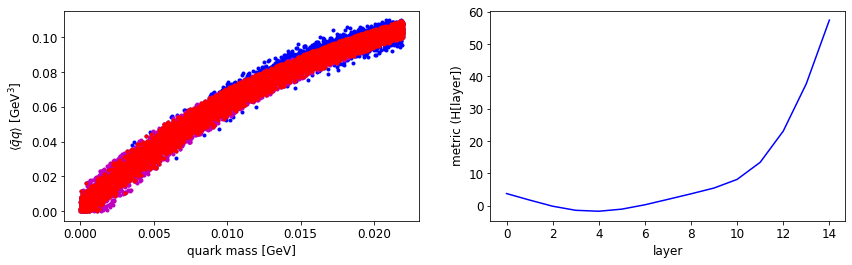

training epoch: 3300,   loss: 0.019959863275289536
lambda: 0.06859836727380753,   AdS radius: 2.685068368911743[1/GeV]
[ 3.768328    1.7545555  -0.14445403 -1.4106307  -1.7010752  -1.0493075
  0.29665533  1.9788765   3.689077    5.4824924   8.153612   13.436916
 23.08345    37.739487   57.415253  ]


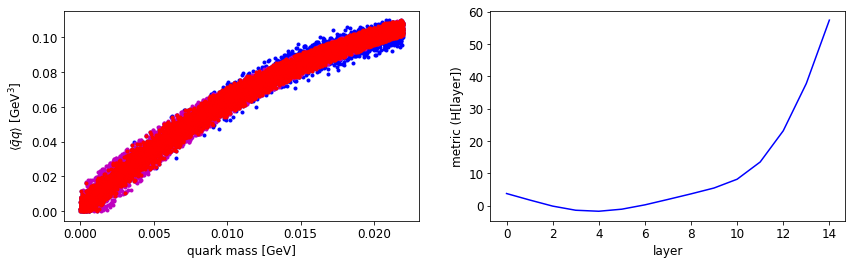

training epoch: 3400,   loss: 0.02042722888290882
lambda: 0.06876449286937714,   AdS radius: 2.6753158569335938[1/GeV]
[ 3.769941    1.773568   -0.11855376 -1.3966296  -1.7051569  -1.0674716
  0.26874462  1.9469731   3.6637185   5.4793224   8.190858   13.516463
 23.156965   37.76562    57.357853  ]


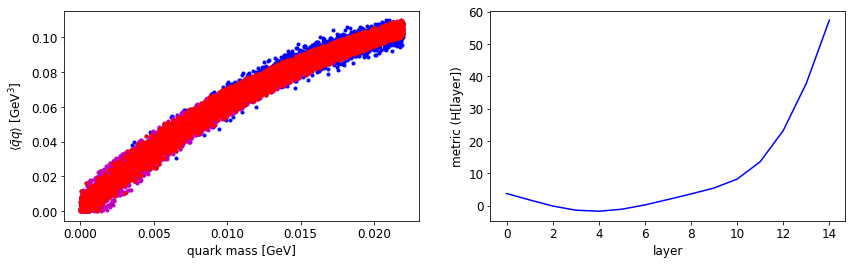

training epoch: 3500,   loss: 0.020158665254712105
lambda: 0.06890071928501129,   AdS radius: 2.6708738803863525[1/GeV]
[ 3.7722065   1.792357   -0.09275378 -1.381836   -1.7080439  -1.0843608
  0.24222939  1.9166161   3.6399064   5.477514    8.229118   13.596504
 23.235275   37.81478    57.375362  ]


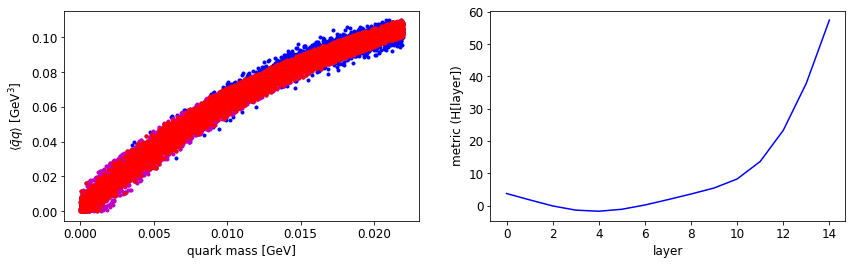

training epoch: 3600,   loss: 0.018991481512784958
lambda: 0.07070647925138474,   AdS radius: 2.6620872020721436[1/GeV]
[ 3.7739573  1.8098433 -0.0681743 -1.3673728 -1.7107726 -1.1009364
  0.2161582  1.8867997  3.616553   5.475739   8.266428  13.674136
 23.312637  37.869057  57.416447 ]


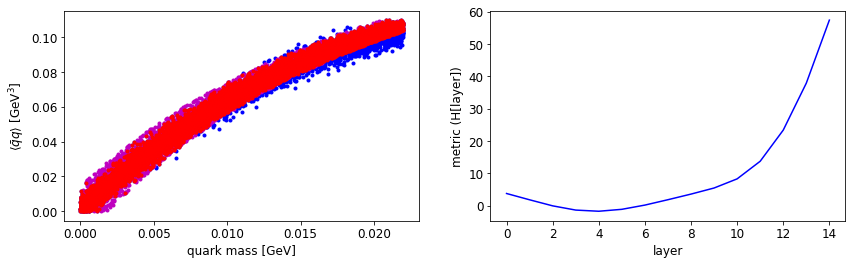

training epoch: 3700,   loss: 0.019824059680104256
lambda: 0.06889108568429947,   AdS radius: 2.6534321308135986[1/GeV]
[ 3.7746739e+00  1.8257254e+00 -4.5099877e-02 -1.3538010e+00
 -1.7142839e+00 -1.1184611e+00  1.8904547e-01  1.8559109e+00
  3.5920367e+00  5.4726281e+00  8.3018293e+00  1.3748083e+01
  2.3384327e+01  3.7908882e+01  5.7408230e+01]


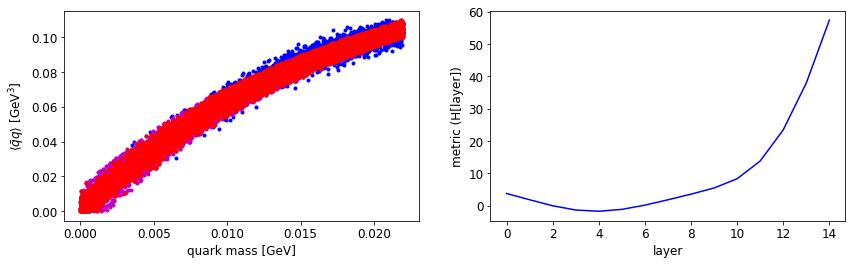

training epoch: 3800,   loss: 0.019185258075594902
lambda: 0.07486647367477417,   AdS radius: 2.6549131870269775[1/GeV]
[ 3.7773473e+00  1.8432409e+00 -2.0272920e-02 -1.3379599e+00
 -1.7154589e+00 -1.1339084e+00  1.6386658e-01  1.8269155e+00
  3.5694430e+00  5.4714427e+00  8.3390417e+00  1.3823040e+01
  2.3456818e+01  3.7949802e+01  5.7407963e+01]


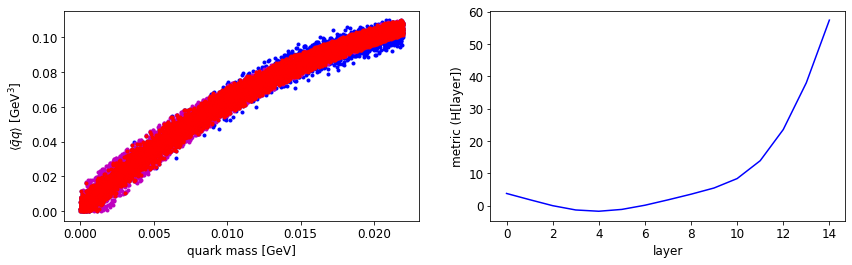

training epoch: 3900,   loss: 0.019588833674788475
lambda: 0.07255876064300537,   AdS radius: 2.647517442703247[1/GeV]
[ 3.7789688e+00  1.8592584e+00  3.1253945e-03 -1.3229568e+00
 -1.7172886e+00 -1.1501234e+00  1.3782917e-01  1.7970097e+00
  3.5458148e+00  5.4690261e+00  8.3740702e+00  1.3893851e+01
  2.3521997e+01  3.7970421e+01  5.7339661e+01]


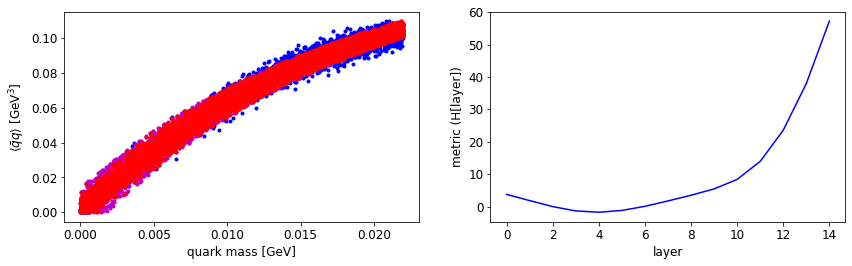

training epoch: 4000,   loss: 0.019172998145222664
lambda: 0.07488660514354706,   AdS radius: 2.6440868377685547[1/GeV]
[ 3.7808075e+00  1.8753150e+00  2.6588105e-02 -1.3073652e+00
 -1.7183858e+00 -1.1657438e+00  1.1227345e-01  1.7675397e+00
  3.5225029e+00  5.4666476e+00  8.4085617e+00  1.3962295e+01
  2.3581638e+01  3.7975616e+01  5.7236198e+01]


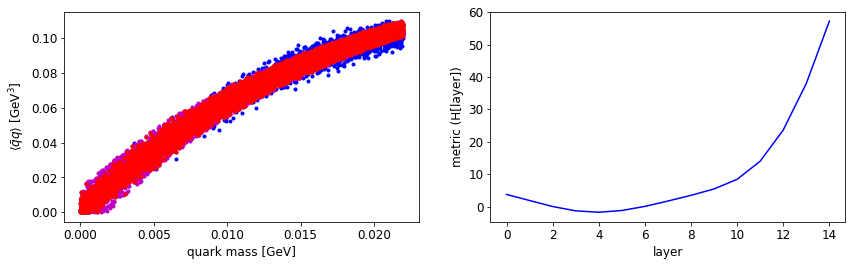

training epoch: 4100,   loss: 0.018966739997267723
lambda: 0.07586117833852768,   AdS radius: 2.639352321624756[1/GeV]
[ 3.7821057e+00  1.8903445e+00  4.9083240e-02 -1.2921422e+00
 -1.7194780e+00 -1.1813524e+00  8.6792663e-02  1.7382518e+00
  3.4994683e+00  5.4645863e+00  8.4433813e+00  1.4031237e+01
  2.3646519e+01  3.8008751e+01  5.7241547e+01]


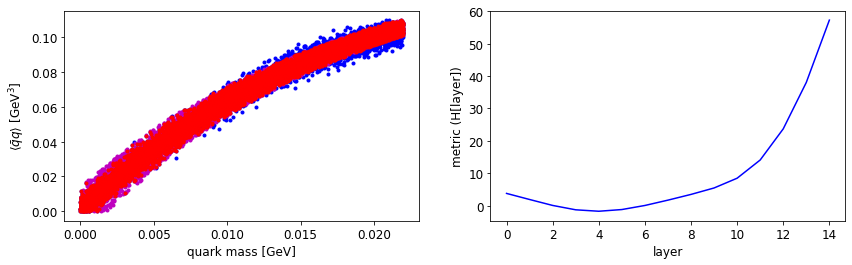

training epoch: 4200,   loss: 0.0188753679394722
lambda: 0.07498884946107864,   AdS radius: 2.6410560607910156[1/GeV]
[ 3.7835166   1.905041    0.07123365 -1.2767553  -1.7201834  -1.1966096
  0.06162157  1.709299    3.476814    5.462827    8.47817    14.099721
 23.71299    38.052647   57.279636  ]


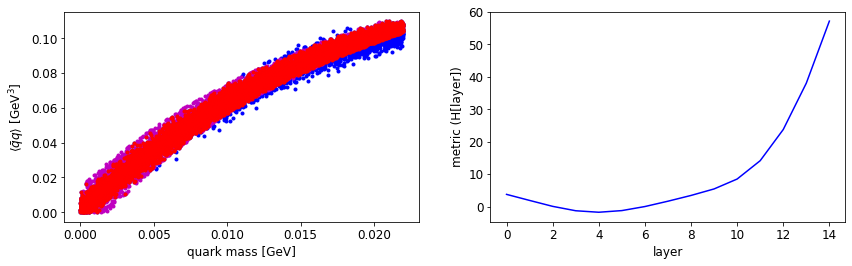

training epoch: 4300,   loss: 0.019593406468629837
lambda: 0.07357440143823624,   AdS radius: 2.6316537857055664[1/GeV]
[ 3.7845814e+00  1.9190627e+00  9.2684776e-02 -1.2615892e+00
 -1.7208205e+00 -1.2118547e+00  3.6361694e-02  1.6801468e+00
  3.4536364e+00  5.4599380e+00  8.5101690e+00  1.4161571e+01
  2.3764050e+01  3.8047943e+01  5.7166157e+01]


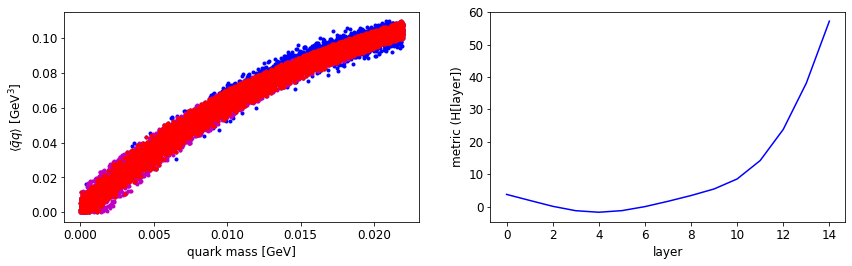

training epoch: 4400,   loss: 0.018978210166096687
lambda: 0.07492026686668396,   AdS radius: 2.637446880340576[1/GeV]
[ 3.7872415e+00  1.9341847e+00  1.1519483e-01 -1.2448676e+00
 -1.7195623e+00 -1.2251351e+00  1.3134150e-02  1.6531956e+00
  3.4329093e+00  5.4597731e+00  8.5454578e+00  1.4228835e+01
  2.3830694e+01  3.8101181e+01  5.7237186e+01]


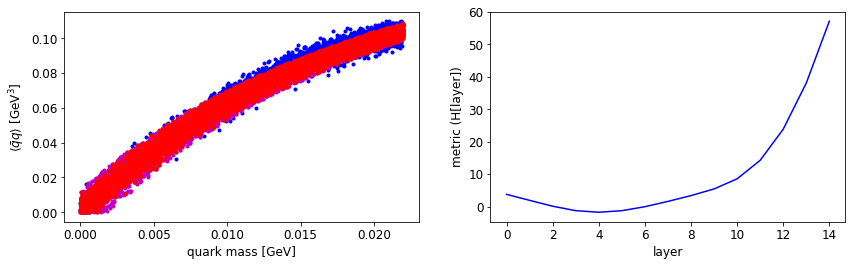

training epoch: 4500,   loss: 0.018661610782146454
lambda: 0.0775732696056366,   AdS radius: 2.6346497535705566[1/GeV]
[ 3.7889087e+00  1.9479851e+00  1.3626829e-01 -1.2291355e+00
 -1.7188884e+00 -1.2389235e+00 -1.0620291e-02  1.6256169e+00
  3.4112356e+00  5.4578695e+00  8.5772400e+00  1.4288749e+01
  2.3881931e+01  3.8107933e+01  5.7167656e+01]


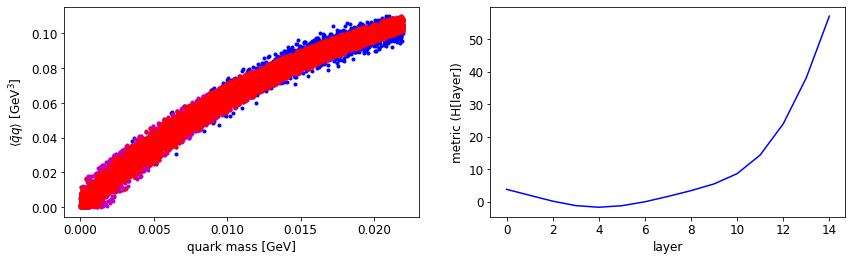

training epoch: 4600,   loss: 0.019279679283499718
lambda: 0.07707515358924866,   AdS radius: 2.6254427433013916[1/GeV]
[ 3.7898021e+00  1.9609113e+00  1.5655251e-01 -1.2138565e+00
 -1.7186292e+00 -1.2533886e+00 -3.5255376e-02  1.5970604e+00
  3.3885336e+00  5.4549479e+00  8.6075916e+00  1.4345812e+01
  2.3927071e+01  3.8097622e+01  5.7049484e+01]


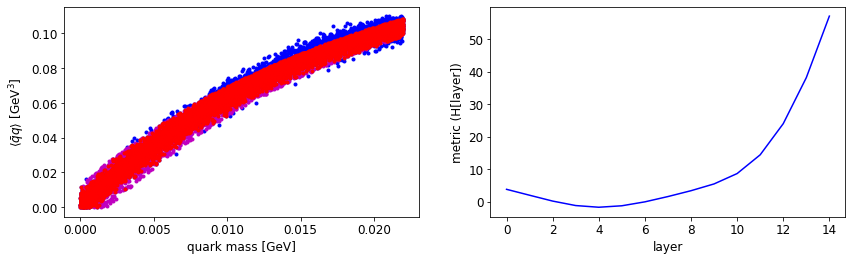

training epoch: 4700,   loss: 0.018773924559354782
lambda: 0.07947287708520889,   AdS radius: 2.616130828857422[1/GeV]
[ 3.7922356   1.9748037   0.17761768 -1.1972433  -1.7163247  -1.265385
 -0.05713436  1.5714562   3.3687887   5.4545937   8.639884   14.404929
 23.980427   38.122314   57.04585   ]


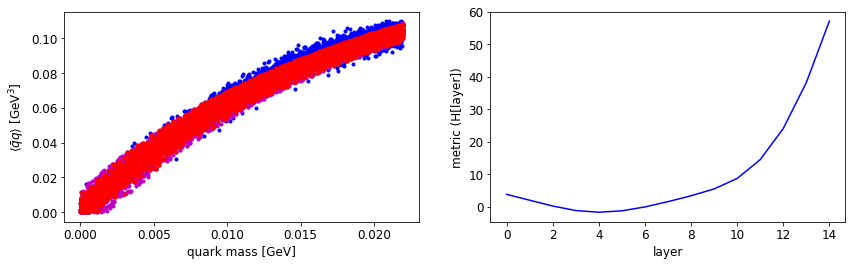

training epoch: 4800,   loss: 0.018580136820673943
lambda: 0.08254365622997284,   AdS radius: 2.6114652156829834[1/GeV]
[ 3.7930512   1.9869319   0.19699135 -1.1820598  -1.7153941  -1.2789893
 -0.08080075  1.544039    3.3473606   5.4528575   8.671172   14.46356
 24.036367   38.162064   57.089848  ]


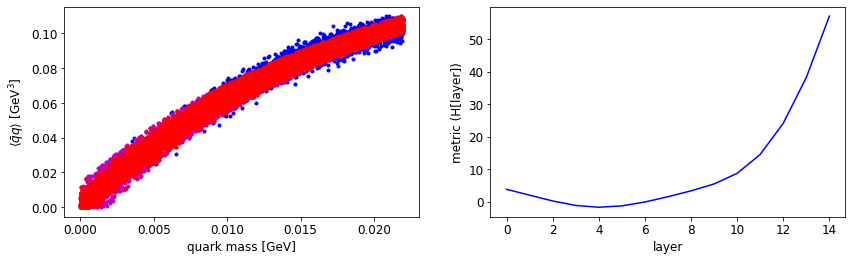

training epoch: 4900,   loss: 0.01900607906281948
lambda: 0.08153636008501053,   AdS radius: 2.6106326580047607[1/GeV]
[ 3.7937205   1.9985818   0.21581027 -1.1671584  -1.7145905  -1.2928205
 -0.10484608  1.5161448   3.3253222   5.4502788   8.700794   14.518687
 24.08497    38.178066   57.048767  ]


In [46]:
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        loss = Test.loss2(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [ ]:
print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)